## conda environments

When accessing this notebook via the JASMIN Jupyter Notebook service, select the correct conda environment from the list of available kernels.

## Imports

In [38]:
from os import path
import pandas as pd
import matplotlib.pyplot as plt
from data_classes import HealthData
import numpy as np
import requests
import pandas as pd
from os import makedirs, path, listdir
from tqdm import tqdm
import zipfile as zpf
import matplotlib.pyplot as plt
import xlrd
from openpyxl import load_workbook
import wandb

## Code

### Daily mortality
Daily mortality data at regional scale. Here we select for the Greater London region using region code E12000007.

In [27]:
region_code = "E12000007"
start_year = 1981
end_year = 2018

In [28]:
urls = {}
urls.update(dict.fromkeys(list(range(1981, 2014+1)), "https://www.ons.gov.uk/file?uri=/peoplepopulationandcommunity/birthsdeathsandmarriages/deaths/adhocs/005459dailydeathoccurrencesenglandregionsofenglandandwales1970to2014/dailydeathoccurrences19702014.zip"))
urls.update(dict.fromkeys(list(range(2013, 2017+1)), "https://www.ons.gov.uk/file?uri=/peoplepopulationandcommunity/birthsdeathsandmarriages/deaths/adhocs/009728dailydeathoccurrencesregionsofenglandandwales2013to2016/dailydeathoccurrences20132017.xls"))
urls.update(dict.fromkeys(list(range(2015, 2018+1)), "https://www.ons.gov.uk/file?uri=/peoplepopulationandcommunity/birthsdeathsandmarriages/deaths/adhocs/11189dailydeathsenglishregionsandwales2015to2018occurrences/dailydeathsfinal.xlsx"))

In [33]:
mortality = HealthData()

In [25]:
mortality.download_and_log(region_code, start_year, end_year, urls)

In [34]:
daily_df = mortality.read()

In [35]:
daily_df.shape

(13879, 1)

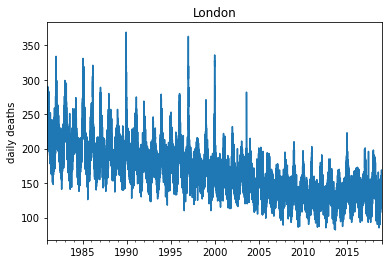

In [36]:
daily_df.plot(legend=False, title="London").set_ylabel("daily deaths")
plt.show()

### Population data

In [88]:
# Move to data classes when finished

class PopData():
    def __init__(self):
        self.tmp_folder = path.join(path.abspath(""), "tmp")
        
        if not path.exists(self.tmp_folder):
            makedirs(self.tmp_folder)

    def download(self, url, verbose=False):
        self.filename = path.basename(url)
        _, self.extension = path.splitext(self.filename)
        self.filepath = path.join(self.tmp_folder, self.filename)
        
        request = requests.get(url)
        file = open(self.filepath, 'wb')
        file.write(request.content)
        file.close()
        if verbose:
            print(f"Saved to {self.filename}")
        if self.extension == ".zip":
            self.zipfiles = zpf.ZipFile(self.filepath).namelist()
            if verbose:
                print("Contains zip files:")
                [print(f"[{i}] {self.zipfiles[i]}") for i in range(len(self.zipfiles))]
        elif self.extension == ".xls":
            workbook = xlrd.open_workbook(self.filepath)
            self.sheets = workbook.sheet_names()
            if verbose:
                print(f"Contains xls sheets: {self.sheets}")
        elif self.extension == ".xlsx":
            workbook = load_workbook(self.filepath)
            self.sheets = workbook.sheetnames
            if verbose:
                print(f"Contains xlsx sheets: {self.sheets}")
                
    def unzip(self, file="all", verbose=False):
        with zpf.ZipFile(self.filepath, 'r') as zip_ref:
            if file =="all":                                       # Extract all zipped files.
                zip_ref.extractall(self.tmp_folder)
            else:                                                  # Extract one specified file,
                zip_ref.extract(file, self.tmp_folder)            # then
                self.filename = path.basename(file)                # reset the file name, path and extension info.
                _, self.extension = path.splitext(self.filename)
                self.filepath = path.join(self.tmp_folder, self.filename)
             
            if verbose:
                print(f"Unzipped {file}.")
            if self.extension == ".xls":
                workbook = xlrd.open_workbook(self.filepath)
                self.sheets = workbook.sheet_names()
                if verbose:
                    print(f"Contains xls sheets: {self.sheets}")
            elif self.extension == ".xlsx":
                workbook = load_workbook(self.filepath)
                self.sheets = workbook.sheetnames
                if verbose:
                    print(f"Contains xlsx sheets: {self.sheets}")
        
    def download_and_log(self, url, region_name):
        with wandb.init(project="AQmortality", job_type="load-data") as run:
            self.download(url)
    
            df = pd.DataFrame()

            for sheet in ["Table 3", "Table 4"]:
                tmp_df = self.read_xls(sheet, verbose=False)
                tmp_df = tmp_df.loc[tmp_df[0].apply(lambda x: isinstance(x, int))].reset_index(drop=True)[[0]].rename(columns={0:"date"}).join(tmp_df.loc[tmp_df[1]=="London"].reset_index(drop=True)[[2]].rename(columns={2:"population"})).set_index("date")
                tmp_df.index = pd.to_datetime(tmp_df.index, format="%Y") + pd.tseries.offsets.DateOffset(months=6) # Set these as mid-year estimates
                if df.empty:
                    df = tmp_df.copy()
                else:
                    df = df.append(tmp_df.copy())
                    
            columns = df.columns.to_list()

            raw_data = wandb.Artifact(
                "population-raw", type="dataset",
                description=f"Raw annual population data for total {region_name} region. Data is extracted from source Excel file (not logged using Weights and Biases).",
                metadata={"source":url,
                         "shapes":[df[column].shape for column in columns],
                         "columns":columns})

            for column in columns:
                with raw_data.new_file(column + ".npz", mode="wb") as file:
                        np.savez(file, x=df.index, y=df[column].values)

            run.log_artifact(raw_data)
        
        [remove(path.join(self.tmp_folder, file)) for file in listdir(self.tmp_folder)]
        
    def read_csv(self, verbose=True, index_col="date", parse_dates=True):
        if verbose:
            print(f"Reading {self.filename}...")
        return pd.read_csv(self.filepath, index_col=index_col, parse_dates=parse_dates)
    
    def read_xls(self, sheet_name, verbose=False):
        if verbose:
            print(f"Reading {self.filename}...")
        if self.extension == ".xls":
            return pd.read_excel(self.filepath, sheet_name)
        elif self.extension == ".xlsx":
            workbook = load_workbook(self.filepath)
            worksheet = workbook[sheet_name]
            return pd.DataFrame(worksheet.values)
        
    def read(self):
        with wandb.init(project="AQmortality", job_type="read-data") as run:
            raw_data_artifact = run.use_artifact('population-raw:latest')
            data_folder = raw_data_artifact.download()
            filepath = path.join(data_folder, f"population.npz")
            data = np.load(filepath, allow_pickle=True)
            df = pd.DataFrame(index=pd.DatetimeIndex(data["x"]), data=data["y"], columns=["population"])
        return df
    
    def resample_time_and_log(self, key, method):
        with wandb.init(project="AQmortality", job_type="resample-data") as run:
            raw_data_artifact = run.use_artifact('population-raw:latest')
            data_folder = raw_data_artifact.download()
            filepath = path.join(data_folder, f"population.npz")
            data = np.load(filepath, allow_pickle=True)
            df = pd.DataFrame(index=pd.DatetimeIndex(data["x"]), data=data["y"].astype(int), columns=["population"])
            
            resampled_df = df.resample(key).asfreq().interpolate(method=method)
            columns = resampled_df.columns.to_list()
            resample_data = wandb.Artifact(
                "population-resample", type="dataset",
                description=f"Resampled population data to daily resolution by {method} interpolation.",
                metadata={"shapes":[resampled_df[column].shape for column in columns],
                         "columns":columns,
                        "key":key,
                         "method":method})
            for column in columns:
                with resample_data.new_file(column + ".npz", mode="wb") as file:
                        np.savez(file, x=df.index, y=resampled_df[column].values)

            run.log_artifact(resample_data)
        
        return resampled_df  

#### Download & process the population data

In [89]:
url = "https://www.ons.gov.uk/file?uri=/peoplepopulationandcommunity/populationandmigration/populationestimates/datasets/populationestimatesforukenglandandwalesscotlandandnorthernireland/mid2001tomid2019detailedtimeseries/regionalpopestimatesforenglandandwales19712019.xlsx"
region_name = "London"
pop_data = PopData()

In [60]:
pop_data.download_and_log(url, region_name)

#### Load the data

In [73]:
population_df = pop_data.read()
population_df.shape

(39, 1)

#### Plot the dataframe

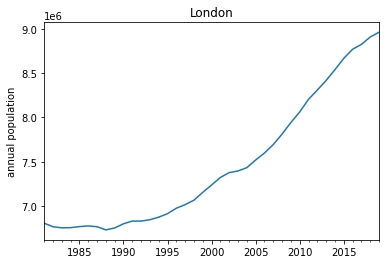

In [62]:
population_df.plot(legend=False, title="London").set_ylabel("annual population")
plt.show()

#### Linear interpolation of annual data

In [90]:
key = "D"
method = "linear"

In [91]:
linear_df = pop_data.resample_time_and_log(key, method)

In [92]:
linear_df.shape

(13880, 1)

### Calculating deaths as a fraction of population

Daily deaths

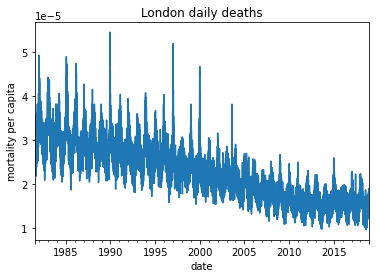

In [19]:
df = linear_df.join(daily_df).dropna()
df["deaths_per_capita"] = df["deaths"]/df["total_population"]
df["deaths_per_capita"].plot(legend=False, title="London daily deaths").set_ylabel("mortality per capita")
plt.show()

In [20]:
df.to_csv(path.join(path.join(path.abspath(""), "mortality_data/daily"), "daily_mortality_percapita_London.csv"))

In [21]:
df.shape

(13698, 3)